## Description of Notebook
This Notebook includes analysis of combined cleaned CitiBike data and NYPD bike related accidents data.

### Importing Libraries
We import essential libraries

In [1]:
import os
import sys
import numpy as np
from numpy import hstack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
from sklearn.neighbors import BallTree

In [2]:
# load cleaned 2023 citibike data and nypd bike accidents data

df_2023_cleaned = pd.read_csv('citibike_2023_cleaned.csv')
df_bike_accidents = pd.read_csv('nypd_bike_accidents.csv')

/tmp/ipykernel_4079512/322024208.py:3: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023_cleaned = pd.read_csv('citibike_2023_cleaned.csv')


### High-Risk Area Detection
Where do CitiBike rides face highest accident exposure? We identify CitiBike stations that are close to NYPD accident locations.

In [3]:
# collect unique citibike start stations
# groupby gives one row per station and agg computes mean coordinates, 
# in case there are small variations for the same station

stations = (df_2023_cleaned.dropna(subset=['start_station_name', 'start_lat', 'start_lng'])
            .groupby('start_station_name', as_index=False)
            .agg({'start_lat': 'mean', 'start_lng': 'mean'}))

print(stations.shape)

(2305, 3)


Though CitiBike claims ~750 active stations, there were 2305 unique stations collected from the dataset. The dataset may include Decommissioned stations or Temporary stations or Duplicates from typos (most suspected). 

In [7]:
# collect accident coordinates 
accidents = df_bike_accidents[['LATITUDE', 'LONGITUDE']].dropna()

# convert decimal degrees to radians for Haversine distance
stations_rad = np.radians(stations[['start_lat', 'start_lng']])
accidents_rad = np.radians(accidents[['LATITUDE', 'LONGITUDE']])

# spatial BallTree with accident data
accident_tree = BallTree(accidents_rad, metric='haversine')

# find how many accidents are within 150 meters (0.15 km)
# sklearn balltree .query_radius -> checks for neighbors within a given radius 
radius_km = 0.15 # needs to be converted to angle in radians (divide by Earth's radius)
indices = accident_tree.query_radius(stations_rad, r=radius_km/6371)  

# count number of accidents nearby each station and rank stations by accident count
risk_scores = [len(i) for i in indices]
stations['accidents_within_150m'] = risk_scores
stations['risk_rank'] = stations['accidents_within_150m'].rank(method='dense', ascending=False)

In [8]:
# add a borough to the nearest accident

# collect accident records with boroughs
accidents_with_borough = df_bike_accidents[['LATITUDE', 'LONGITUDE', 'BOROUGH']].dropna()

# convert coordinates decimal degrees to radians for Haversine distance
accidents_rad_borough = np.radians(accidents_with_borough[['LATITUDE', 'LONGITUDE']])

# make a BallTree using only accidents with known borough
borough_tree = BallTree(accidents_rad_borough, metric='haversine')

# find the nearest accident borough for each CitiBike station
# query the nearest accident, k=1; find closet point for each station
dist, ind = borough_tree.query(stations_rad, k=1)

# assign borough from nearest accident 
# extract the borough from nearest accident point and assign name to new column
stations['nearest_borough'] = accidents_with_borough.iloc[ind.flatten()]['BOROUGH'].values

In [14]:
# rank stations by accident count
stations_sorted = stations.sort_values(by='accidents_within_150m', ascending=False)

# top 20 risky stations
stations_sorted.head(20)

,start_station_name,start_lat,start_lng,accidents_within_150m,risk_rank,nearest_borough
916,Delancey St & Eldridge St,40.719469,-73.991453,161,1.0,MANHATTAN
623,Bergen St & Flatbush Ave,40.681167,-73.975740,154,2.0,BROOKLYN
2276,Willow Ave & 12 St,40.744323,-73.974500,137,3.0,MANHATTAN
661,Broadway & E 14 St,40.734535,-73.990738,134,4.0,MANHATTAN
1414,Jay St & Tech Pl,40.695105,-73.987137,129,5.0,BROOKLYN
1230,Forsyth St & Grand St,40.717818,-73.993145,127,6.0,MANHATTAN
1228,Forsyth St & Broome St,40.719122,-73.992526,123,7.0,MANHATTAN
382,6 St & Grand St,40.725013,-73.996503,120,8.0,MANHATTAN
700,Broadway & W 58 St,40.766785,-73.981743,117,9.0,MANHATTAN
1931,St Nicholas Ave & W 126 St,40.811240,-73.951900,116,10.0,MANHATTAN


In [18]:
top_10 = stations_sorted[['start_station_name', 'accidents_within_150m', 'risk_rank', 'nearest_borough']]
top_10.head(10)

,start_station_name,accidents_within_150m,risk_rank,nearest_borough
916,Delancey St & Eldridge St,161,1.0,MANHATTAN
623,Bergen St & Flatbush Ave,154,2.0,BROOKLYN
2276,Willow Ave & 12 St,137,3.0,MANHATTAN
661,Broadway & E 14 St,134,4.0,MANHATTAN
1414,Jay St & Tech Pl,129,5.0,BROOKLYN
1230,Forsyth St & Grand St,127,6.0,MANHATTAN
1228,Forsyth St & Broome St,123,7.0,MANHATTAN
382,6 St & Grand St,120,8.0,MANHATTAN
700,Broadway & W 58 St,117,9.0,MANHATTAN
1931,St Nicholas Ave & W 126 St,116,10.0,MANHATTAN


In [15]:
# save stations sorted to csv
stations_sorted.to_csv("stations_sorted.csv", index=False)

In [19]:
# visualize the top 20 high-risk CitiBike stations on a map using folium 

import folium

# top 20 risky stations
top_stations = stations_sorted.head(20)

# base map centered around lat and long of the stations
mean_lat = top_stations['start_lat'].mean()
mean_lng = top_stations['start_lng'].mean()

nyc_map = folium.Map(location=[mean_lat, mean_lng], zoom_start=10)

# assign colors to accident counts
def get_risk_color(count):
    if count >= 150:
        return 'darkred'
    elif count >= 135:
        return 'red'
    elif count >= 120:
        return 'orange'
    else:
        return 'green'

# plot the stations on the map
for _, row in top_stations.iterrows():
    popup_text = (f"<b>Station:</b> {row['start_station_name']}<br>"
                  f"<b>Accidents:</b> {row['accidents_within_150m']}")
    
    icon_color = get_risk_color(row['accidents_within_150m'])

    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        icon=folium.Icon(color=icon_color, icon='info-sign'),
        popup=popup_text
    ).add_to(nyc_map)

# custom HTML legend box
legend_html = """
<div style="
    position: fixed; 
    bottom: 40px; left: 40px; width: 160px; height: 120px; 
    background-color: white; 
    border:2px solid grey; 
    z-index:9999; 
    font-size:14px;
    padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
">
<b>Risk Level</b><br>
<i style="color:darkred">⬤</i> ≥ 150<br>
<i style="color:red">⬤</i> ≥ 135<br>
<i style="color:orange">⬤</i> ≥ 120<br>
<i style="color:green">⬤</i> &lt; 120
</div>
"""

# add legend to the map
nyc_map.get_root().html.add_child(folium.Element(legend_html))

# Save to file
nyc_map.save('nyc_map.html')

# show constructed map
nyc_map

### Time-Based Risk Pattern Analysis

In [20]:
# plotting library
sys.path.append('/home/timi/Desktop/Timi/Data/AXA')
from plot_essentials import *

/tmp/ipykernel_3111558/1032629524.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('fig_comb_time1.pdf', frameon=False, bbox_inches='tight')


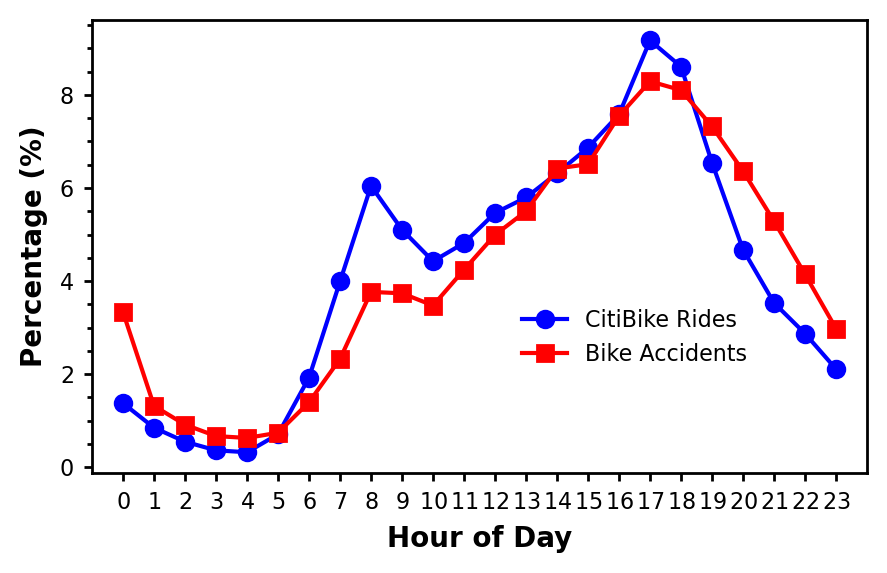

In [21]:
# Hourly comparison

# counts of CitiBike usage by hour
citibike_hour = df_2023_cleaned['ride_hour'].value_counts().sort_index() # sort from 0 to 23

# obtain percentage, reassign index to hour and percentages
citibike_hour = (citibike_hour / citibike_hour.sum() * 100).reset_index()
citibike_hour.columns = ['hour', 'citibike_pct']

# counts of bike accidents by hour
accident_hour = df_bike_accidents['hour'].value_counts().sort_index()
accident_hour = (accident_hour / accident_hour.sum() * 100).reset_index()
accident_hour.columns = ['hour', 'accident_pct']

# plot
fig, ax = simple_plot_init([r'Hour of Day', r'Percentage (%)'], font_size=10, figsize=[5, 3], dpi=200)

ax.plot(citibike_hour['hour'], citibike_hour['citibike_pct'], label='CitiBike Rides', color='blue', marker='o')
ax.plot(accident_hour['hour'], accident_hour['accident_pct'], label='Bike Accidents', color='red', marker='s')

ax.set_xticks(range(0, 24))
ax.set_xlim(-1, 24)
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.7, 0.3], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
plt.savefig('fig_comb_time1.pdf', frameon=False, bbox_inches='tight')
plt.show()

/tmp/ipykernel_3111558/1258009559.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('fig_comb_time2.pdf', frameon=False, bbox_inches='tight')


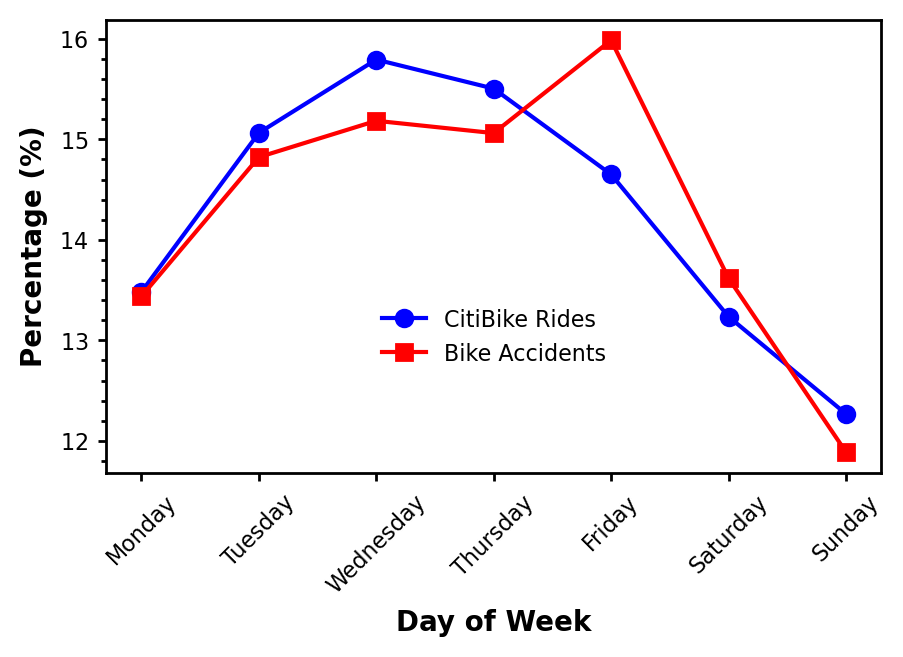

In [22]:
# Day of Week comparison

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# counts of CitiBike usage by day
citibike_day = df_2023_cleaned['ride_dayofweek'].value_counts().reindex(day_order)
citibike_day = (citibike_day / citibike_day.sum() * 100).reset_index()
citibike_day.columns = ['day', 'citibike_pct']

# counts of bike accidents by day
accident_day = df_bike_accidents['day_of_week'].value_counts().reindex(day_order)
accident_day = (accident_day / accident_day.sum() * 100).reset_index()
accident_day.columns = ['day', 'accident_pct']

# plot
fig, ax = simple_plot_init([r'Day of Week', r'Percentage (%)'], font_size=10, figsize=[5, 3], dpi=200)

ax.plot(citibike_day['day'], citibike_day['citibike_pct'], label='CitiBike Rides', color='blue', marker='o')
ax.plot(accident_day['day'], accident_day['accident_pct'], label='Bike Accidents', color='red', marker='s')

ax.set_xticks(range(7))
ax.set_xticklabels(accident_day['day'], rotation=45)
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.5, 0.3], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
plt.savefig('fig_comb_time2.pdf', frameon=False, bbox_inches='tight')
plt.show()

/tmp/ipykernel_3111558/2757729365.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('fig_comb_time3.pdf', frameon=False, bbox_inches='tight')


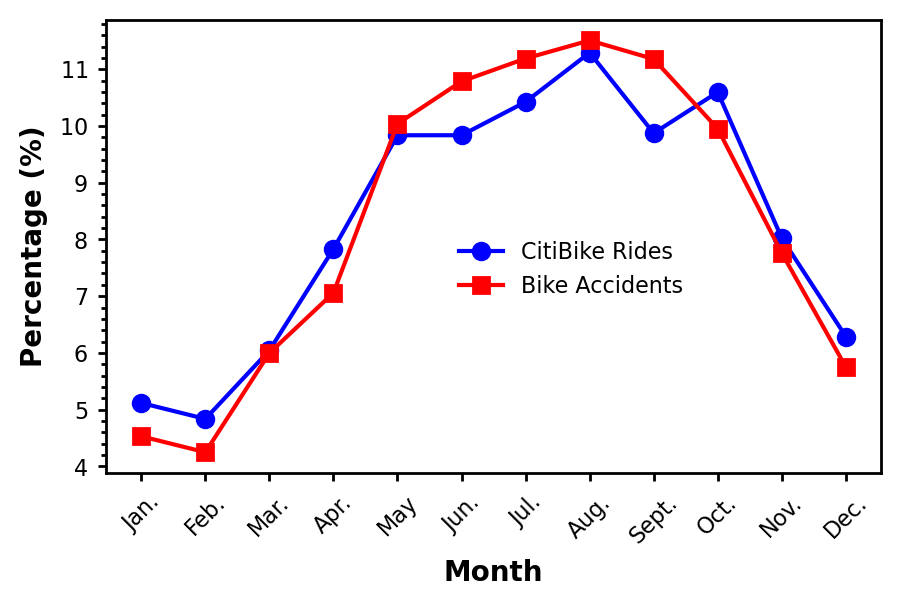

In [23]:
# Month comparison

month_labels = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 
                'Sept.', 'Oct.', 'Nov.', 'Dec.']

# counts of CitiBike usage by month
citibike_month = df_2023_cleaned['ride_month'].value_counts().sort_index()
citibike_month = (citibike_month / citibike_month.sum() * 100).reset_index()
citibike_month.columns = ['month', 'citibike_pct']

# counts of bike accidents by month
accident_month = df_bike_accidents['month'].value_counts().sort_index()
accident_month = (accident_month / accident_month.sum() * 100).reset_index()
accident_month.columns = ['month', 'accident_pct']

# plot
fig, ax = simple_plot_init([r'Month', r'Percentage (%)'], font_size=10, figsize=[5, 3], dpi=200)

ax.plot(citibike_month['month'], citibike_month['citibike_pct'], label='CitiBike Rides', color='blue', marker='o')
ax.plot(accident_month['month'], accident_month['accident_pct'], label='Bike Accidents', color='red', marker='s')

ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels, rotation=45)
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.6, 0.45], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
plt.savefig('fig_comb_time3.pdf', frameon=False, bbox_inches='tight')
plt.show()

/tmp/ipykernel_3111558/2460845807.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('fig_comb_time4.pdf', frameon=False, bbox_inches='tight')


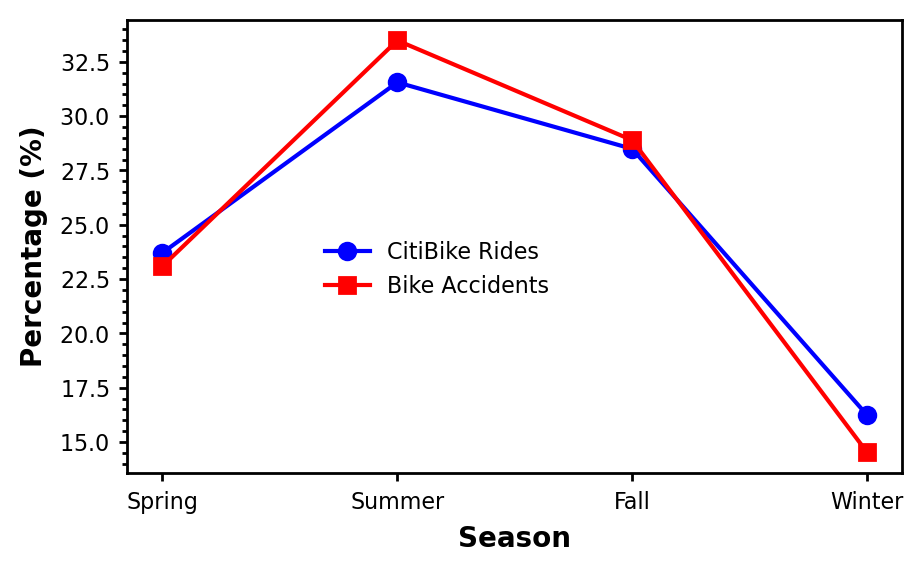

In [24]:
# Season comparison

season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# counts of CitiBike usage by season
citibike_season = df_2023_cleaned['ride_season'].value_counts().reindex(season_order)
citibike_season = (citibike_season / citibike_season.sum() * 100).reset_index()
citibike_season.columns = ['season', 'citibike_pct']

# counts of bike accidents by season
accident_season = df_bike_accidents['season'].value_counts().reindex(season_order)
accident_season = (accident_season / accident_season.sum() * 100).reset_index()
accident_season.columns = ['season', 'accident_pct']

# plot
fig, ax = simple_plot_init([r'Season', r'Percentage (%)'], font_size=10, figsize=[5, 3], dpi=200)

ax.plot(citibike_season['season'], citibike_season['citibike_pct'], label='CitiBike Rides', color='blue', marker='o')
ax.plot(accident_season['season'], accident_season['accident_pct'], label='Bike Accidents', color='red', marker='s')

ax.set_xticks(range(4))
ax.set_xticklabels(accident_season['season'])
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.4, 0.45], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
plt.savefig('fig_comb_time4.pdf', frameon=False, bbox_inches='tight')
plt.show()

### Route Risk Scoring Analysis
We combine CitiBike trip routes and nypd bike accidents to score routes risk; assigning a risk score to commonly used CitiBike routes based on their proximity to past bike accidents

In [90]:
# df_2023_cleaned['route'] has already been created
# we limit analysis based on top 100 commonly used routes

top_routes = df_2023_cleaned['route'].value_counts().head(100).index
df_routes = df_2023_cleaned[df_2023_cleaned['route'].isin(top_routes)].copy()

In [91]:
# obtain midpoint coordinates of the routes
df_routes['mid_lat'] = (df_routes['start_lat'] + df_routes['end_lat']) / 2
df_routes['mid_lng'] = (df_routes['start_lng'] + df_routes['end_lng']) / 2

# convert route midpoints coordinates to radians
route_coords = np.radians(df_routes[['mid_lat', 'mid_lng']])

# collect accident coordinates and convert to radians (already done in previous analysis)

accidents = df_bike_accidents[['LATITUDE', 'LONGITUDE']].dropna()
accident_coords = np.radians(accidents[['LATITUDE', 'LONGITUDE']])

In [95]:
# spatial BallTree with accident data
accident_tree = BallTree(accident_coords, metric='haversine')

# query for accidents within 150 meters of each route midpoint
radius_km = 0.15
indices = accident_tree.query_radius(route_coords, r=radius_km/6371)

# count number of accidents for each route
df_routes['route_risk_score'] = [len(i) for i in indices]

# rank the routes, data is grouped by route and mean of risk score is taken per route
route_risks = df_routes.groupby('route')['route_risk_score'].mean().reset_index()
route_risks['risk_rank'] = route_risks['route_risk_score'].rank(method='dense', ascending=False)
route_risks_sorted = route_risks.sort_values(by='route_risk_score', ascending=False)

# top 20 risky routes
route_risks_sorted.head(20)

,route,route_risk_score,risk_rank
69,University Pl & E 14 St - W 13 St & 5 Ave,147.049410,1.0
23,Broadway & W 58 St - Broadway & W 58 St,117.212139,2.0
36,E 2 St & Avenue C - E 1 St & 1 Ave,101.820555,3.0
86,W 41 St & 8 Ave - Broadway & W 41 St,86.441454,4.0
75,W 15 St & 6 Ave - W 21 St & 6 Ave,83.005887,5.0
43,E 7 St & Ave B - Cooper Square & Astor Pl,79.999699,6.0
38,E 33 St & 1 Ave - 6 Ave & W 33 St,75.742302,7.0
28,Central Park S & 6 Ave - 7 Ave & Central Park ...,73.337367,8.0
87,W 42 St & 8 Ave - 11 Ave & W 41 St,72.277553,9.0
6,11 Ave & W 41 St - W 42 St & 8 Ave,72.029364,10.0
